In [30]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Redes Neurais Artificiais - Exercício 2
## Aluno: Victor São Paulo Ruela



## 1. Problema Não-Linearmente Separável

Inicialmente, define-se a função geradora dos dados:

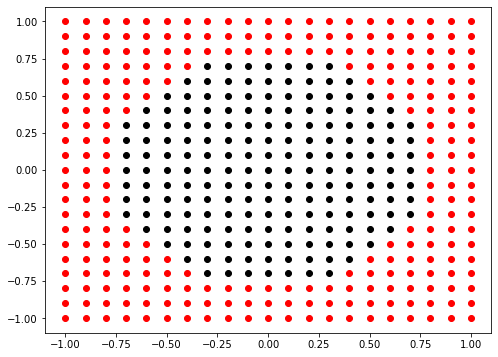

In [70]:
def func_circle(radius=0.6):
    x = np.arange(-1, 1 + 0.1, step=0.1)
    y = np.arange(-1, 1 + 0.1, step=0.1)

    xy = np.array([(xi, yi) for xi in x for yi in y])

    z = np.sum(xy ** 2, axis=1)
    z_class = 1 * (z > radius)

    df = pd.DataFrame()
    df['x'] = xy[:, 0]
    df['y'] = xy[:, 1]
    df['class'] = z_class.flatten()

    return df


def plot_func(data):
    t_class0 = data['class'] == 0
    t_class1 = data['class'] == 1

    fig, ax = plt.subplots(figsize=(8,6))


    ax.scatter(data.loc[t_class0, 'x'],
                data.loc[t_class0, 'y'], color='black')
    ax.scatter(data.loc[t_class1, 'x'], data.loc[t_class1, 'y'], color='red')
    return fig, ax

data = func_circle()
fig, _ = plot_func(data)
fig.show()

Conforme pode ser visto na figura acima, os dados não são linearmente separáveis. Logo, um mapeamento não-linear pode ser aplicado para que seja possível realizar sua solução em um novo espaço linearizado. 

Utilizando o Perceptron simples e uma transformação dos dados de entrada por uma função de kernel Gaussiano (RBF), é possível resolver este problema sem modificar o algoritmo. Inicialmente, sua implementação é feita considerando um problema de classificação binário, logo o algoritmo do gradiente descendente não será necessário.

In [32]:
# Implementação do perceptron simples para um problema de classificação binário
class LinearPerceptron:
    def __init__(self, eta=0.1, tol=0.0001, max_epochs=200):
        self.eta = eta
        self.tol = tol
        self.max_epochs = max_epochs

    def predict(self, x, w):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        u = x_aug @ w
        return u, 1.0 * (u >= 0)

    def train(self, x_train, y_train):
        # initialize the weight matrix
        N, n = x_train.shape
        x_aug = np.hstack((-np.ones((N, 1)), x_train))

        wt = np.random.rand(n+1) - 0.5
        n_epochs = 0
        e_vec = []

        while(n_epochs < self.max_epochs):
            # generate random indexes order
            xseq = np.arange(N)
            np.random.shuffle(xseq)
            error_array = []

            for i_rand in xseq:
                yhati = 1.0 * ((x_aug[i_rand, :] @ wt) >= 0)
                ei = y_train[i_rand] - yhati
                # calculate step size
                dw = self.eta * ei * x_aug[i_rand, :]
                # update weight vector
                wt = wt + dw

                error_array.append(ei ** 2)

            # increment number of epochs
            n_epochs = n_epochs + 1
            e_vec.append(np.sum(error_array) / N)

        return wt, e_vec

Em seguida, é criada uma rotina que recebe um conjunto de dados de entrada e desenha a superfície de decisão aprendida para o modelo.

In [71]:
def plot_decision_boundary(data, kernel=None):
    fig, ax = plt.subplots(figsize=(8,6))

    x = np.arange(-1, 1 + 0.1, step=0.01)
    y = np.arange(-1, 1 + 0.1, step=0.01)

    xx, yy = np.meshgrid(x, y)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    if kernel != None:
        r1, r2 = kernel(r1), kernel(r2)
  
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    
    # train the model
    model = LinearPerceptron()
    y_train = data['class'].to_numpy()
    x_train = data[['x', 'y']].to_numpy()
    if kernel != None:
        x_train = kernel(x_train)

    w, _ = model.train(x_train, y_train)

    # make predictions for the grid
    _, yhat = model.predict(grid, w)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    ax.contourf(xx, yy, zz, cmap='Paired')
   
    t_class0 = data['class'] == 0
    t_class1 = data['class'] == 1
    ax.scatter(data.loc[t_class0, 'x'],
                data.loc[t_class0, 'y'], cmap='Paired')
    ax.scatter(data.loc[t_class1, 'x'], data.loc[t_class1, 'y'], cmap='Paired')

Como exercício, primeiro tentamos aprender um modelo usando diretamente os dados na sua forma original.

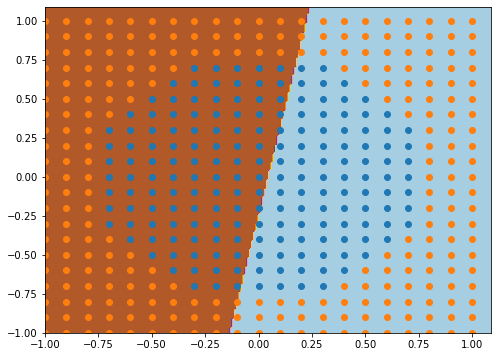

In [74]:
# Linear perceptron
plot_decision_boundary(data)

Conforme esperado, o Perceptron simples é incapaz de aprender a superfício de separação correta para esses dados, uma vez que esta pode ser somente linear.

Em seguida, aplicamos uma transformação Gaussiana nos dados, por meio de um Kernel RBF 
$$h(x, \mu_i) = e^{-(x-\mu_i)^2/2r^2}$$
O valor de média com média zero e raio 0.6, uma vez que conhecemos a função geradora dos dados. 

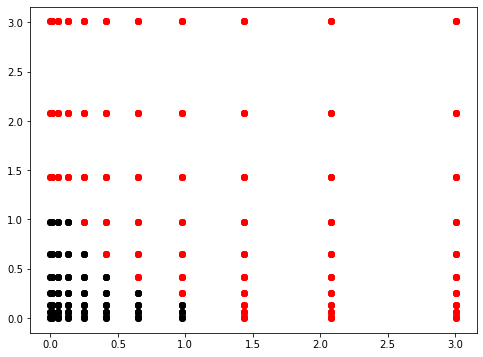

In [77]:
radius = 0.6 # using the same radius used to generate the data
def rbf(x): return np.expm1((x ** 2) / (2*(radius**2)))

xrbf = rbf(x_train)
data_rbf = pd.DataFrame()
data_rbf['x'] = xrbf[:, 0]
data_rbf['y'] = xrbf[:, 1]
data_rbf['class'] = y_train

fig, _ax = plot_func(data_rbf)
fig.show()

No gráfico acima, pode-se notar que os dados são facilmente separados pelo Perceptron simples no espaço linearizado. Se executarmos a mesma rotina anterior, porém considerando os dados transformados, é possível chegar à superfície de decisão esperado no espaõ original, conforme exibido na figura abaixo.

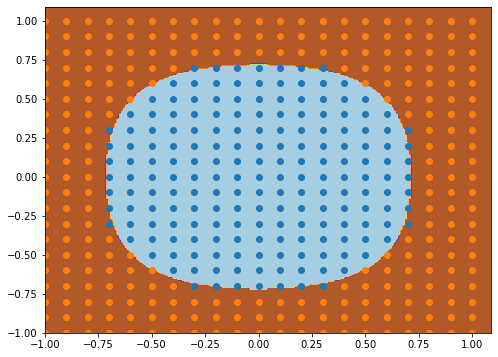

In [78]:
# Train RBF (Gaussian) kernel
plot_decision_boundary(data, rbf)